
=== audcad ===
 Level  Buy  Sell  Total
     1  121   116    237
     2   35    32     67
     3   10     9     19
     4    3     3      6
     5    1     3      4
     6    0     1      1


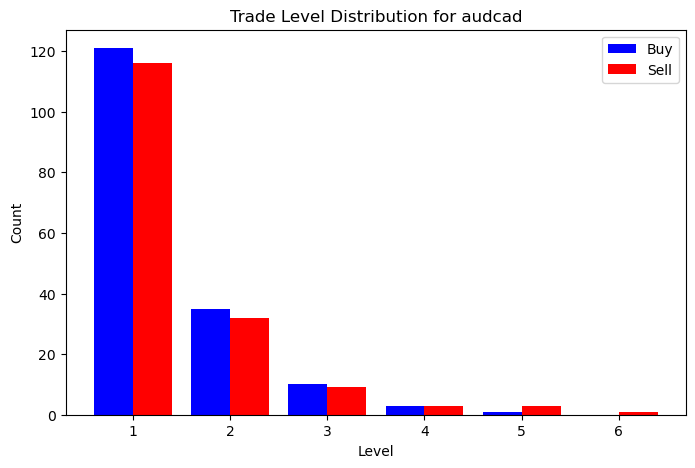


=== audchf ===
 Level  Buy  Sell  Total
     1   91    66    157
     2   27    16     43
     3   10     6     16
     4    2     2      4
     5    1     2      3
     6    1     2      3
     7    1     1      2
     8    1     1      2
     9    1     1      2
    10    1     0      1
    11    1     0      1
    12    1     0      1


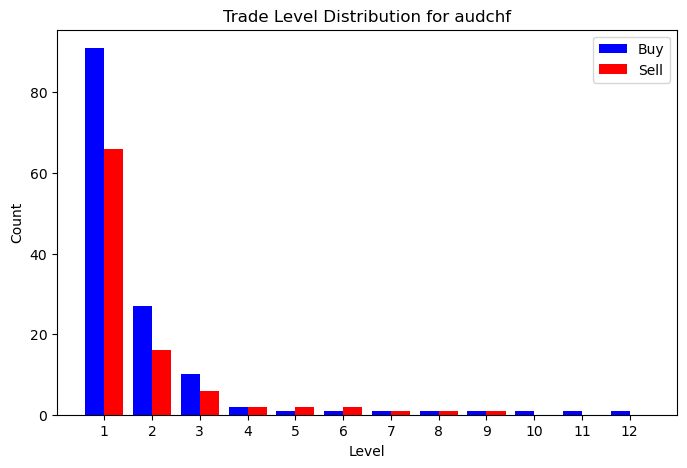


=== audnzd ===
 Level  Buy  Sell  Total
     1  102   106    208
     2   20    28     48
     3   10     8     18
     4    2     2      4
     5    1     1      2
     6    1     1      2
     7    1     0      1
     8    1     0      1


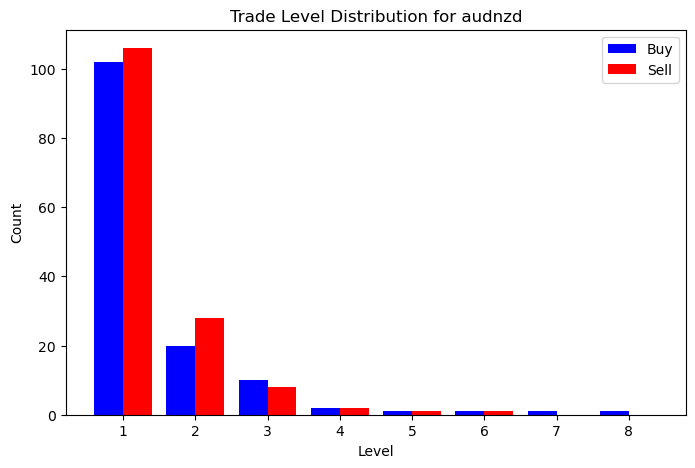


=== audusd ===
 Level  Buy  Sell  Total
     1  115   102    217
     2   27    28     55
     3   10     5     15
     4    3     2      5
     5    2     1      3
     6    2     1      3
     7    1     1      2
     8    1     0      1
     9    1     0      1
    10    1     0      1
    11    1     0      1
    12    1     0      1


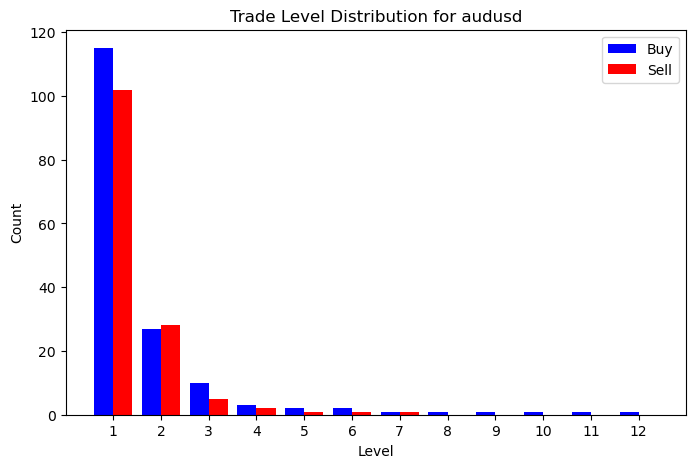


=== cadchf ===
 Level  Buy  Sell  Total
     1   68    70    138
     2   23    20     43
     3    8     6     14
     4    4     2      6
     5    3     1      4
     6    2     1      3
     7    2     1      3
     8    1     0      1
     9    1     0      1
    10    1     0      1
    11    1     0      1
    12    1     0      1
    13    1     0      1
    14    1     0      1
    15    1     0      1
    16    1     0      1
    17    1     0      1


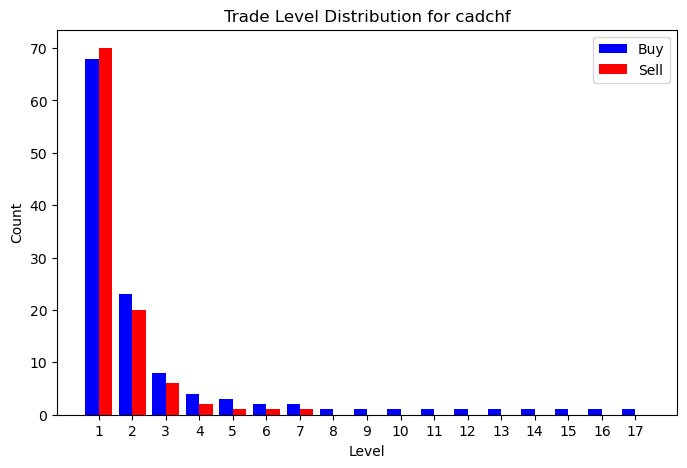


=== euraud ===
 Level  Buy  Sell  Total
     1  139   147    286
     2   21    22     43
     3    4     5      9
     4    0     3      3
     5    0     1      1


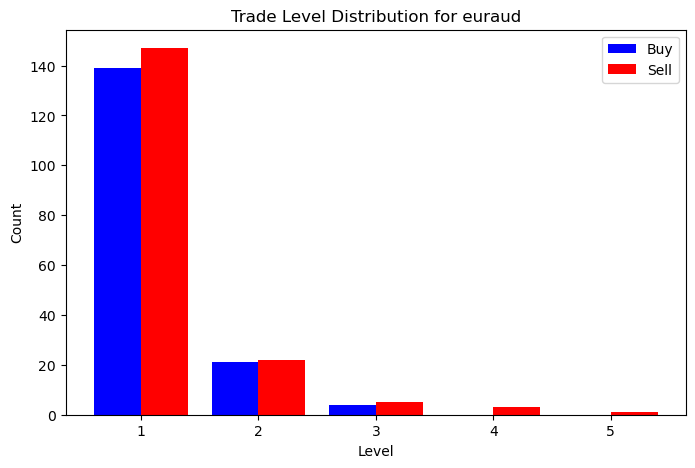


=== eurcad ===
 Level  Buy  Sell  Total
     1  104   121    225
     2   19    27     46
     3    7     9     16
     4    3     3      6
     5    2     2      4
     6    1     2      3
     7    1     1      2


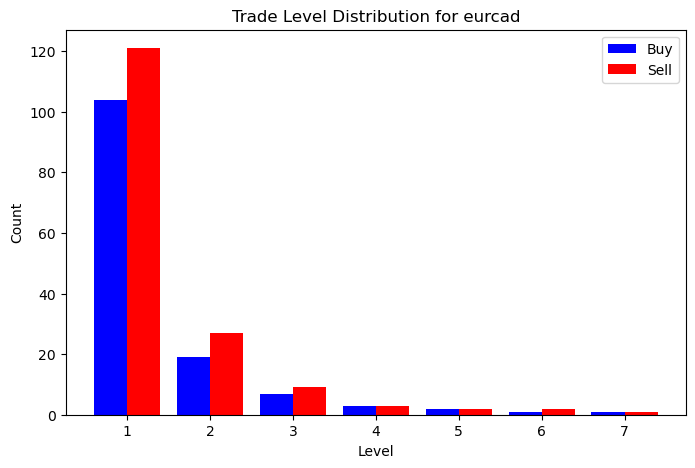


=== eurchf ===
 Level  Buy  Sell  Total
     1  130   108    238
     2   31    29     60
     3   12     9     21
     4    6     6     12
     5    4     3      7
     6    1     1      2
     7    0     1      1


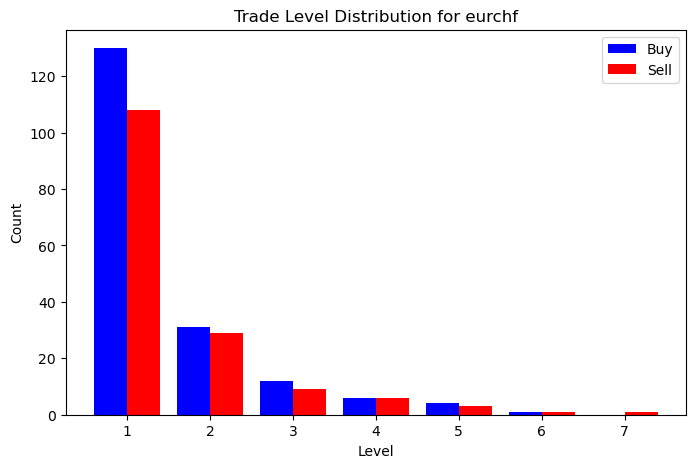


=== eurgbp ===
 Level  Buy  Sell  Total
     1   66    65    131
     2   23    19     42
     3    7     4     11
     4    4     2      6
     5    2     2      4
     6    1     1      2
     7    0     1      1


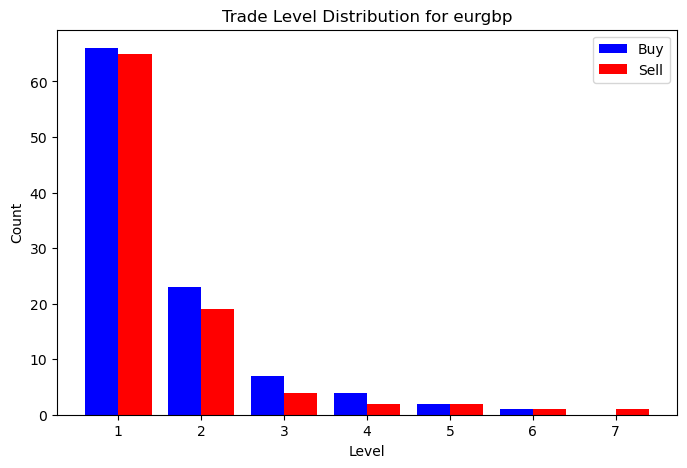


=== eurnzd ===
 Level  Buy  Sell  Total
     1  111    71    182
     2   25    18     43
     3    2     5      7
     4    1     1      2


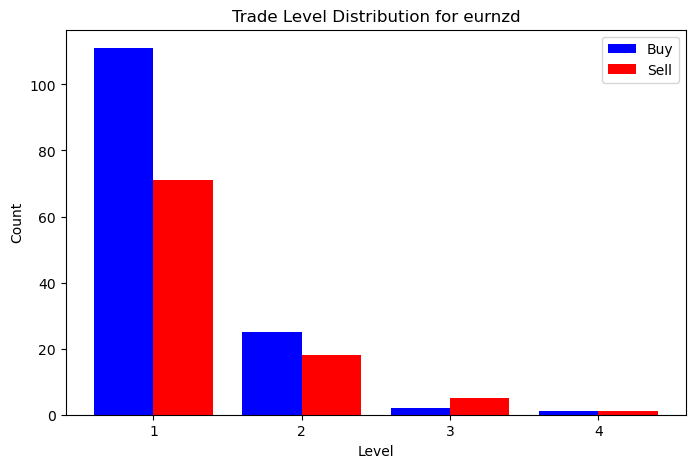


=== eurusd ===
 Level  Buy  Sell  Total
     1  140   127    267
     2   26    23     49
     3    5     8     13
     4    3     1      4


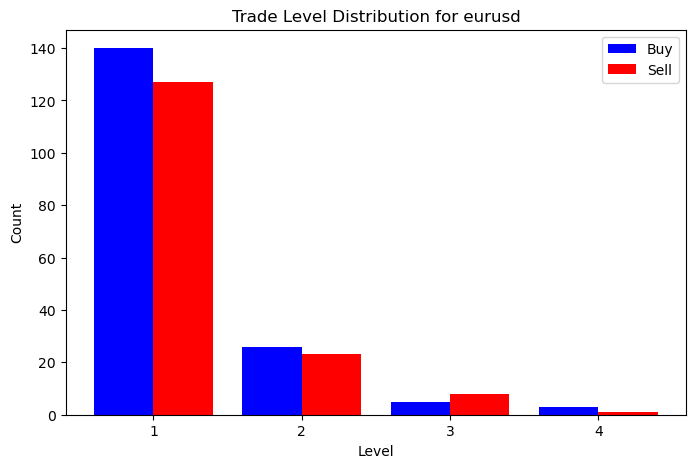


=== gbpaud ===
 Level  Buy  Sell  Total
     1   66    69    135
     2    6    10     16
     3    0     3      3
     4    0     2      2
     5    0     2      2
     6    0     2      2
     7    0     2      2
     8    0     2      2
     9    0     2      2
    10    0     1      1
    11    0     1      1


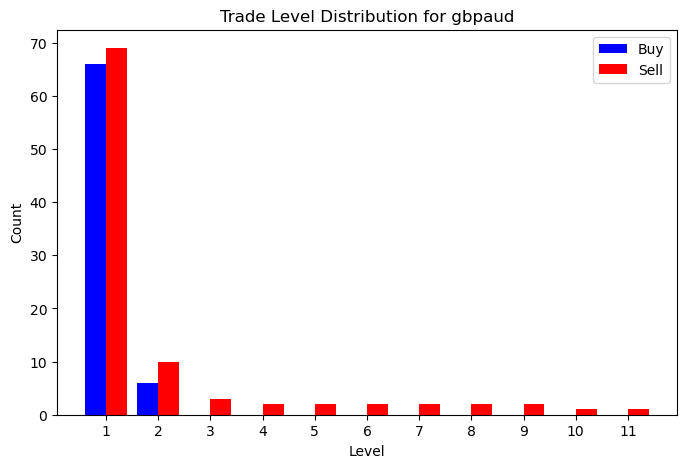


=== gbpcad ===
 Level  Buy  Sell  Total
     1   67   108    175
     2   18    15     33
     3    8     5     13
     4    6     3      9
     5    4     2      6
     6    2     1      3
     7    1     1      2
     8    1     1      2


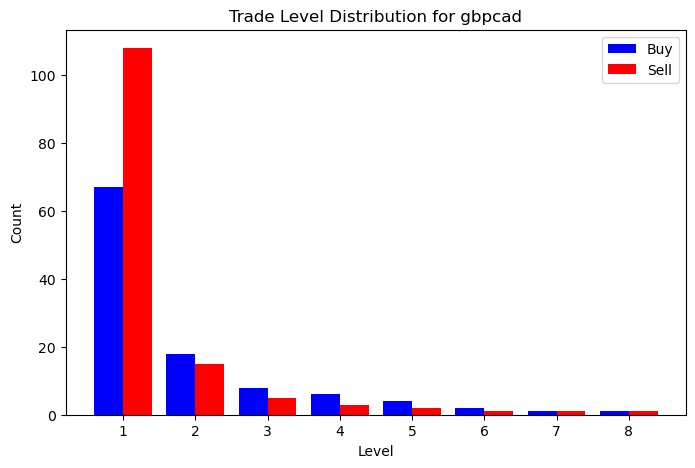


=== gbpchf ===
 Level  Buy  Sell  Total
     1  122   118    240
     2   28    25     53
     3    9     9     18
     4    3     4      7
     5    2     2      4
     6    1     1      2
     7    1     0      1
     8    1     0      1
     9    1     0      1


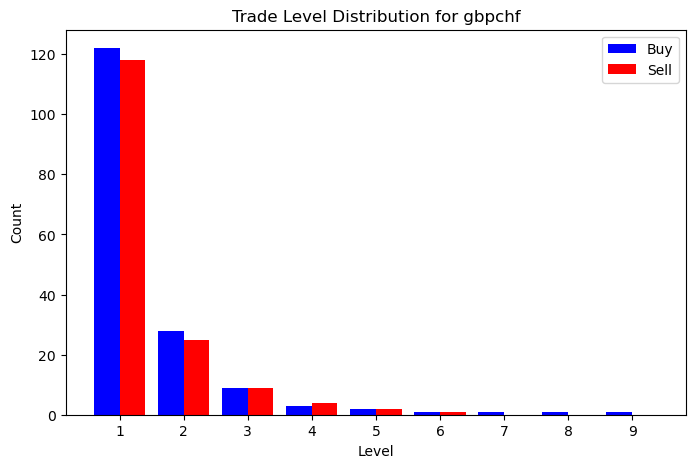


=== gbpnzd ===
 Level  Buy  Sell  Total
     1   32    38     70
     2    9     7     16
     3    3     1      4
     4    2     0      2
     5    2     0      2


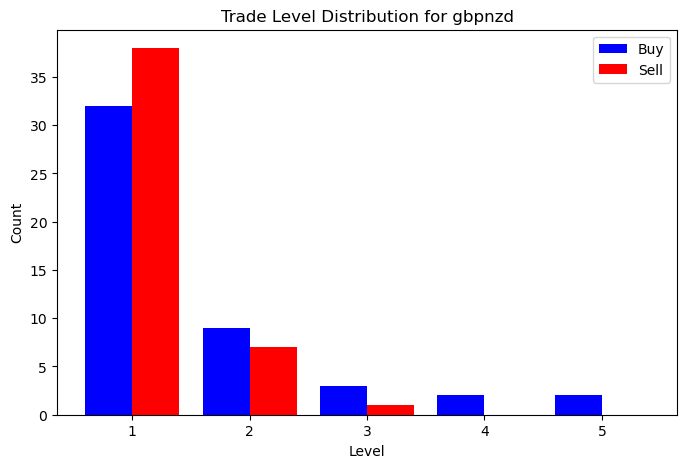


=== gbpusd ===
 Level  Buy  Sell  Total
     1  128   132    260
     2   26    25     51
     3    6     7     13
     4    2     2      4
     5    1     2      3
     6    1     2      3
     7    1     2      3
     8    1     2      3
     9    1     2      3
    10    1     0      1
    11    1     0      1


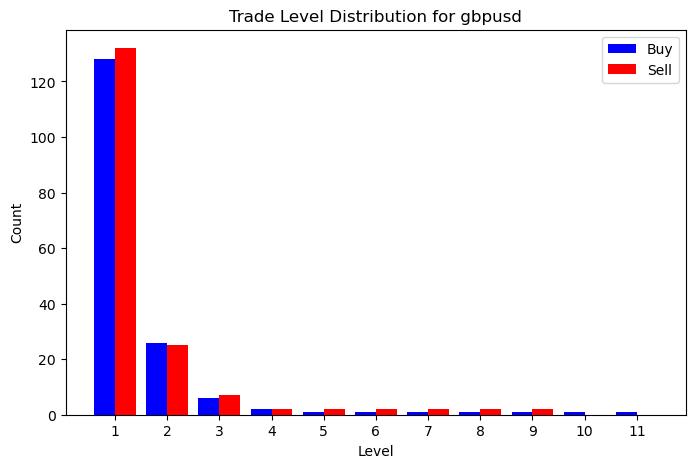


=== nzdcad ===
 Level  Buy  Sell  Total
     1  107   119    226
     2   33    33     66
     3   11    13     24
     4    5     3      8
     5    4     1      5
     6    1     0      1
     7    1     0      1
     8    1     0      1


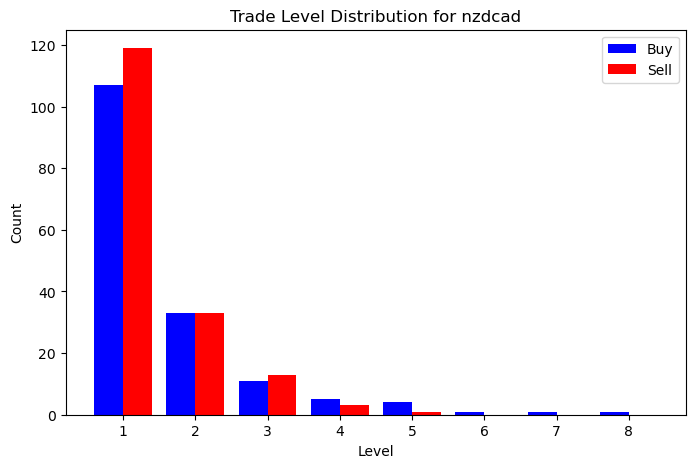


=== nzdchf ===
 Level  Buy  Sell  Total
     1   78    61    139
     2   26    15     41
     3    8     2     10
     4    4     1      5
     5    2     1      3
     6    1     1      2
     7    1     0      1
     8    1     0      1
     9    1     0      1
    10    1     0      1
    11    1     0      1
    12    1     0      1
    13    1     0      1
    14    1     0      1
    15    1     0      1
    16    1     0      1
    17    1     0      1


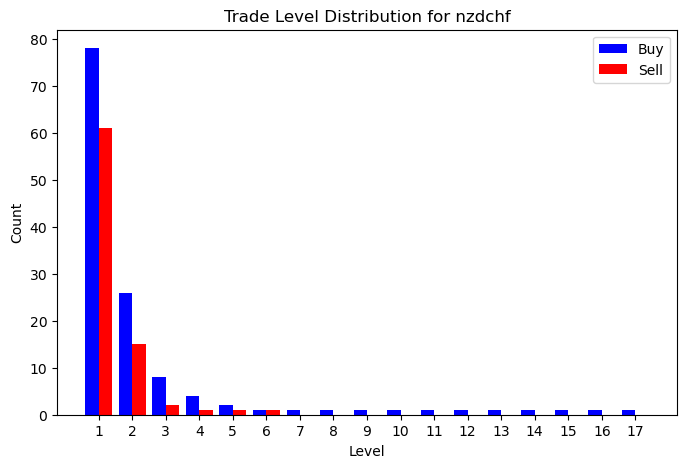


=== nzdusd ===
 Level  Buy  Sell  Total
     1   74    87    161
     2   27    24     51
     3   10     8     18
     4    5     5     10
     5    3     2      5
     6    3     1      4
     7    3     1      4
     8    0     1      1
     9    0     1      1
    10    0     1      1


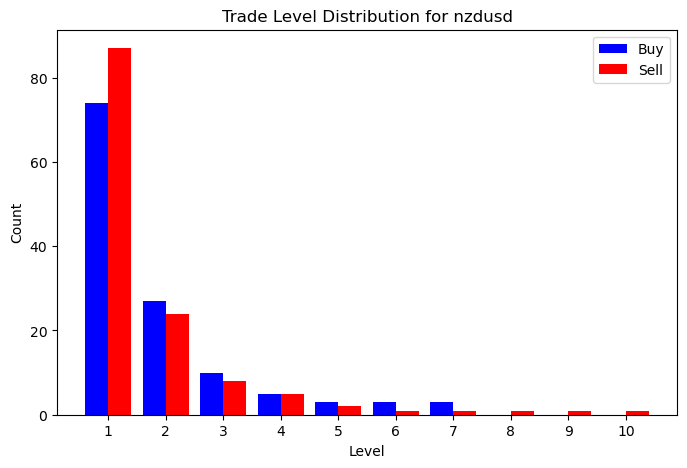


=== usdcad ===
 Level  Buy  Sell  Total
     1  113   137    250
     2   20    28     48
     3    7     6     13
     4    1     4      5
     5    0     1      1


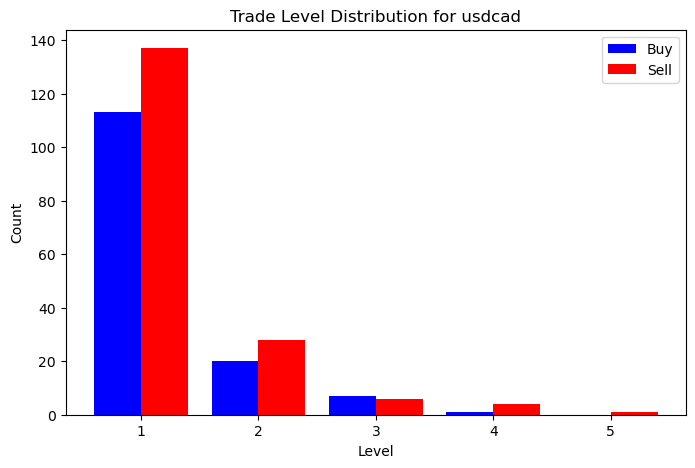


=== usdchf ===
 Level  Buy  Sell  Total
     1  103   110    213
     2   25    21     46
     3    9     6     15
     4    4     3      7
     5    2     2      4
     6    2     0      2
     7    2     0      2


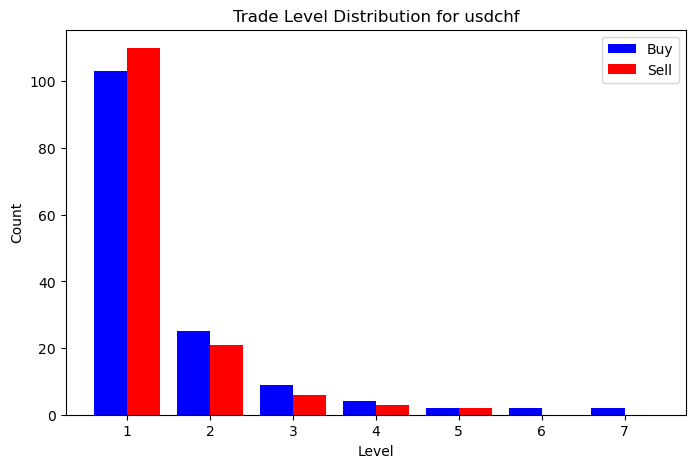


=== xauusd ===
 Level  Buy  Sell  Total
     1   24    55     79
     2    2    10     12
     3    0     4      4
     4    0     2      2
     5    0     2      2


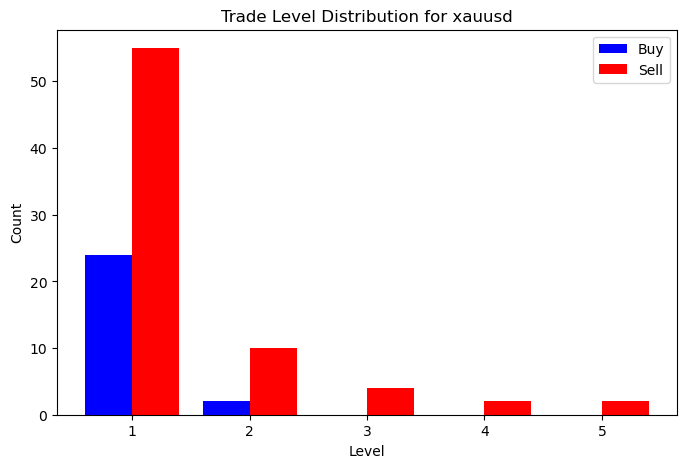

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def read_data(filename):
    df = pd.read_excel(filename)
    return df[['Item', 'Type', 'Size']]

def determine_level(lot_size):
    if lot_size <= 0.04:
        return round(lot_size / 0.01)
    else:
        return round((lot_size - 0.4) / 0.1) + 4

def analyze_trades(df):
    results = {}
    
    for pair in df['Item'].unique():
        pair_df = df[df['Item'] == pair]
        buy_counts = defaultdict(int)
        sell_counts = defaultdict(int)
        
        for _, row in pair_df.iterrows():
            level = determine_level(row['Size'])
            if row['Type'] == 'buy':
                buy_counts[level] += 1
            else:
                sell_counts[level] += 1
        
        all_levels = set(buy_counts.keys()).union(set(sell_counts.keys()))
        table = pd.DataFrame({
            'Level': sorted(all_levels),
            'Buy': [buy_counts[level] for level in sorted(all_levels)],
            'Sell': [sell_counts[level] for level in sorted(all_levels)],
        })
        table['Total'] = table['Buy'] + table['Sell']
        
        results[pair] = table
    
    return results

def plot_results(results):
    for pair, table in results.items():
        plt.figure(figsize=(8, 5))
        x = np.arange(len(table))
        width = 0.4
        
        plt.bar(x - width/2, table['Buy'], width, label='Buy', color='blue')
        plt.bar(x + width/2, table['Sell'], width, label='Sell', color='red')
        
        plt.xlabel('Level')
        plt.ylabel('Count')
        plt.title(f'Trade Level Distribution for {pair}')
        plt.xticks(x, table['Level'])
        plt.legend()
        plt.show()

# Run the analysis
df = read_data('shadowhistory.xlsx')
results = analyze_trades(df)

# Print tables and plot results
for pair, table in results.items():
    print(f"\n=== {pair} ===")
    print(table.to_string(index=False))
    plot_results({pair: table})
